In [22]:
import pandas as pd
data = pd.read_csv('/home/kdt-admin/cleaned_data.csv').dropna(axis=0)

In [23]:
data['문장'].nunique(), data['감정'].nunique()

(173247, 6)

In [24]:
data.drop_duplicates(subset=['문장'], inplace=True)
data.reset_index(drop=True, inplace=True)

## 토큰화 (Kobert)

In [25]:
import torch
from kobert import get_pytorch_kobert_model
input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
model, vocab  = get_pytorch_kobert_model()
sequence_output, pooled_output = model(input_ids, input_mask, token_type_ids)
pooled_output.shape


using cached model. /home/kdt-admin/.cache/kobert_v1.zip
using cached model. /home/kdt-admin/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


torch.Size([2, 768])

In [26]:
vocab

Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")

In [27]:
sequence_output[0]

tensor([[-0.2461,  0.2428,  0.2590,  ..., -0.4861, -0.0731,  0.0756],
        [-0.2478,  0.2420,  0.2552,  ..., -0.4877, -0.0727,  0.0754],
        [-0.2472,  0.2420,  0.2561,  ..., -0.4874, -0.0733,  0.0765]],
       grad_fn=<SelectBackward>)

In [28]:
predefined_args = {
        'attention_cell': 'multi_head',
        'num_layers': 12,
        'units': 768,
        'hidden_size': 3072,
        'max_length': 512,
        'num_heads': 12,
        'scaled': True,
        'dropout': 0.1,
        'use_residual': True,
        'embed_size': 768,
        'embed_dropout': 0.1,
        'token_type_vocab_size': 2,
        'word_embed': None,
    }

In [29]:
def get_kobert_model(model_path, vocab_file, ctx="cpu"):
    bertmodel = BertModel.from_pretrained(model_path, return_dict=False)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(
        vocab_file, padding_token="[PAD]"
    )
    return bertmodel, vocab_b_obj

In [30]:
from typing import Any, Dict, List, Optional
from transformers.tokenization_utils import AddedToken
from transformers import XLNetTokenizer
from transformers import SPIECE_UNDERLINE


class KoBERTTokenizer(XLNetTokenizer):
    padding_side = "right"

    def __init__(
        self,
        vocab_file,
        do_lower_case=False,
        remove_space=True,
        keep_accents=False,
        bos_token="[CLS]",
        eos_token="[SEP]",
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]",
        additional_special_tokens=None,
        sp_model_kwargs: Optional[Dict[str, Any]] = None,
        **kwargs
    ) -> None:
        # Mask token behave like a normal word, i.e. include the space before it
        mask_token = (
            AddedToken(mask_token, lstrip=True, rstrip=False)
            if isinstance(mask_token, str)
            else mask_token
        )

        self.sp_model_kwargs = {} if sp_model_kwargs is None else sp_model_kwargs

        super().__init__(
            vocab_file,
            do_lower_case=do_lower_case,
            remove_space=remove_space,
            keep_accents=keep_accents,
            bos_token=bos_token,
            eos_token=eos_token,
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            additional_special_tokens=additional_special_tokens,
            sp_model_kwargs=self.sp_model_kwargs,
            **kwargs,
        )
        self._pad_token_type_id = 0

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks by concatenating and
        adding special tokens. An XLNet sequence has the following format:
        - single sequence: ``<cls> X <sep>``
        - pair of sequences: ``<cls> A <sep> B <sep>``
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added.
            token_ids_1 (:obj:`List[int]`, `optional`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: List of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return cls + token_ids_0 + sep
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def _tokenize(self, text: str) -> List[str]:
        """Tokenize a string."""
        text = self.preprocess_text(text)
        pieces = self.sp_model.encode(text, out_type=str, **self.sp_model_kwargs)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(
                    piece[:-1].replace(SPIECE_UNDERLINE, "")
                )
                if (
                    piece[0] != SPIECE_UNDERLINE
                    and cur_pieces[0][0] == SPIECE_UNDERLINE
                ):
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks by concatenating and
        adding special tokens. An XLNet sequence has the following format:

        - single sequence: ``<cls> X <sep> ``
        - pair of sequences: ``<cls> A <sep> B <sep>``

        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added.
            token_ids_1 (:obj:`List[int]`, `optional`):
                Optional second list of IDs for sequence pairs.

        Returns:
            :obj:`List[int]`: List of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return cls + token_ids_0 + sep
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Create a mask from the two sequences passed to be used in a sequence-pair classification task. An XLNet
        sequence pair mask has the following format:

        ::

            0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
            | first sequence    | second sequence |

        If :obj:`token_ids_1` is :obj:`None`, this method only returns the first portion of the mask (0s).

        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs.
            token_ids_1 (:obj:`List[int]`, `optional`):
                Optional second list of IDs for sequence pairs.

        Returns:
            :obj:`List[int]`: List of `token type IDs <../glossary.html#token-type-ids>`_ according to the given
            sequence(s).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

In [31]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

In [32]:
#GPU 사용 시
device = torch.device("cuda:0")

In [33]:
import torch
print(torch.__version__)

1.8.1+cu111


In [34]:
# 현재 사용 가능한 디바이스 정보 출력
print(torch.cuda.device_count())  # 사용 가능한 CUDA 디바이스 개수
print(torch.cuda.current_device())  # 현재 CUDA 디바이스의 인덱스
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # 현재 CUDA 디바이스의 이름
print(torch.cuda.is_available())  # CUDA 사용 가능 여부

# 현재 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # 현재 디바이스 출력

1
0
NVIDIA A16-16Q
True
cuda:0


In [35]:
data.loc[(data['감정'] == "중립"), '감정'] = 0  
data.loc[(data['감정'] == "슬픔"), '감정'] = 1  
data.loc[(data['감정'] == "분노"), '감정'] = 2  
data.loc[(data['감정'] == "불안"), '감정'] = 3  
data.loc[(data['감정'] == "행복"), '감정'] = 4  
data.loc[(data['감정'] == "당황"), '감정'] = 5  

In [36]:
data_list = []
for ques, label in zip(data['문장'], data['감정'])  :
    data = []   
    data.append(ques)
    data.append(str(label))

    data_list.append(data)

In [37]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [38]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
# kcbert의 tokenizer와 모델을 불러옴.
kcbert_tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-base")
kcbert = AutoModelForMaskedLM.from_pretrained("beomi/kcbert-base")

result = kcbert_tokenizer.tokenize("너는 내년 대선 때 투표할 수 있어?")
print(result)
print(kcbert_tokenizer.vocab['대선'])
print([kcbert_tokenizer.encode(token) for token in result])

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['너는', '내년', '대선', '때', '투표', '##할', '수', '있어', '?']
9311
[[2, 9039, 3], [2, 8946, 3], [2, 9311, 3], [2, 1003, 3], [2, 8701, 3], [2, 7, 7, 3358, 3], [2, 1931, 3], [2, 8749, 3], [2, 32, 3]]


In [39]:
from transformers import AutoModel, AutoTokenizer
kobert_tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1", use_fast=False)

result = kobert_tokenizer.tokenize("너는 내년 대선 때 투표할 수 있어?")
print(result)
kobert_vocab = kobert_tokenizer.get_vocab()
print([kobert_tokenizer.encode(token) for token in result])

['▁너', '는', '▁내년', '▁대선', '▁때', '▁투표', '할', '▁수', '▁있어', '?']
[[1457, 3, 2], [517, 5760, 3, 2], [1437, 3, 2], [1654, 3, 2], [1844, 3, 2], [4772, 3, 2], [4977, 3, 2], [2872, 3, 2], [3868, 3, 2], [633, 3, 2]]


In [40]:
# Setting parameters
max_len = 75
batch_size = 16
warmup_ratio = 0.1
num_epochs = 2
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [41]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

In [42]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1',tokenizer.vocab_file)

In [43]:
tok=tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False)

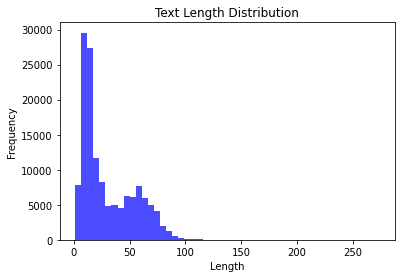

In [44]:
import matplotlib.pyplot as plt

# 텍스트 시퀀스의 길이를 저장할 리스트
lengths = []

# 훈련 데이터셋에 있는 모든 텍스트 시퀀스의 길이 계산
for i in range(len(dataset_train)):
    # 토큰화
    tokens = tok(dataset_train[i][0])
    # 길이 저장
    lengths.append(len(tokens))

# 히스토그램으로 길이 분포 시각화
plt.hist(lengths, bins=50, alpha=0.7, color='b')
plt.title('Text Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()


In [45]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [46]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [47]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [48]:
from tqdm.notebook import tqdm

train_history=[]
test_history=[]
loss_history=[]
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_history.append(train_acc / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

  0%|          | 0/8663 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.810744047164917 train acc 0.125
epoch 1 batch id 201 loss 1.6681848764419556 train acc 0.2658582089552239
epoch 1 batch id 401 loss 1.629830002784729 train acc 0.3725062344139651
epoch 1 batch id 601 loss 1.4746519327163696 train acc 0.44124376039933444
epoch 1 batch id 801 loss 1.1626346111297607 train acc 0.4887640449438202
epoch 1 batch id 1001 loss 0.7883192300796509 train acc 0.5237887112887113
epoch 1 batch id 1201 loss 1.017348289489746 train acc 0.550895087427144
epoch 1 batch id 1401 loss 0.8342302441596985 train acc 0.5706638115631691
epoch 1 batch id 1601 loss 0.8192316889762878 train acc 0.5854153653966271
epoch 1 batch id 1801 loss 1.0767757892608643 train acc 0.5976887840088839
epoch 1 batch id 2001 loss 1.145171880722046 train acc 0.6061656671664168
epoch 1 batch id 2201 loss 0.7734811305999756 train acc 0.6142662426169923
epoch 1 batch id 2401 loss 1.4024641513824463 train acc 0.6213817159516868
epoch 1 batch id 2601 loss 0.6482945084571838 tra

  0%|          | 0/2166 [00:00<?, ?it/s]

epoch 1 test acc 0.767590027700831


  0%|          | 0/8663 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.1429898738861084 train acc 0.6875
epoch 2 batch id 201 loss 0.6607110500335693 train acc 0.7496890547263682
epoch 2 batch id 401 loss 1.2003166675567627 train acc 0.75
epoch 2 batch id 601 loss 0.994924008846283 train acc 0.7533277870216306
epoch 2 batch id 801 loss 0.9550855755805969 train acc 0.7548377028714107
epoch 2 batch id 1001 loss 0.3032655119895935 train acc 0.7561188811188811
epoch 2 batch id 1201 loss 0.8331672549247742 train acc 0.7597314737718568
epoch 2 batch id 1401 loss 0.3211359679698944 train acc 0.7625802997858673
epoch 2 batch id 1601 loss 0.5073190927505493 train acc 0.7652638975640225
epoch 2 batch id 1801 loss 0.5893868803977966 train acc 0.7670391449194892
epoch 2 batch id 2001 loss 0.6329295635223389 train acc 0.7685219890054973
epoch 2 batch id 2201 loss 0.3281526267528534 train acc 0.7691106315311222
epoch 2 batch id 2401 loss 1.575828194618225 train acc 0.7700957934194086
epoch 2 batch id 2601 loss 0.6894496083259583 train acc 0.77

  0%|          | 0/2166 [00:00<?, ?it/s]

epoch 2 test acc 0.7847356879039704


In [49]:
from sklearn.metrics import f1_score

def calculate_f1_score(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for token_ids, valid_length, segment_ids, label in tqdm(dataloader):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='macro')  # macro 평균 사용
    return f1

In [50]:
f1 = calculate_f1_score(model, test_dataloader)
print("Test F1 score:", f1)

  0%|          | 0/2166 [00:00<?, ?it/s]

Test F1 score: 0.7728939740860185
